## 0. Importing Hannes Functions

In [3]:
import pandas as pd
import numpy as np
import csv

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer 
from nltk.stem import PorterStemmer
#nltk.download('stopwords')
from nltk.corpus import stopwords

#!python -m spacy download en_core_web_sm
import spacy
sp = spacy.load('en_core_web_sm')

import re


from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

import os

import re



from tqdm import tqdm
tqdm.pandas()


#getting a library of stopwords and defining a lemmatizer
porter=SnowballStemmer("english")
lmtzr = WordNetLemmatizer()

stop_words = set(stopwords.words('english'))

In [4]:
#additional functions

def strip(word):
    mod_string = re.sub(r'\W+', '', word)
    return mod_string

#the following leaves in place two or more capital letters in a row
#will be ignored when using standard stemming
def abbr_or_lower(word):
    if re.match('([A-Z]+[a-z]*){2,}', word):
        return word
    else:
        return word.lower()

#modular pipeline for stemming, lemmatizing and lowercasing
#note this is NOT lemmatizing using grammar pos
    
def tokenize(text, modulation):
    if modulation<2:
        tokens = re.split(r'\W+', text)
        stems = []
        # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
        for token in tokens:
            lowers=abbr_or_lower(token)
            if lowers not in stop_words:
                if re.search('[a-zA-Z]', lowers):
                    if modulation==0:
                        stems.append(lowers)
                    if modulation==1:
                        stems.append(porter.stem(lowers))
    else:
        sp_text=sp(text)
        stems = []
        lemmatized_text=[]
        for word in sp_text:
            lemmatized_text.append(word.lemma_)
        stems = [abbr_or_lower(strip(w)) for w in lemmatized_text if (abbr_or_lower(strip(w))) and (abbr_or_lower(strip(w)) not in stop_words)]
    return " ".join(stems)

## 1. Session 8 code - This will do pre-preprocessing with td-idf and SVD. I will try with European Commission today.

In [6]:
#loading the data

path="/Users/ruimaciel/Desktop/Barcelona/NLP_I/NLP-Project/"
filename ="data/theeuropeancommission.csv"
EC_data = pd.read_csv(os.path.join(path, filename), sep=',', encoding='utf-8')
EC_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1320 entries, 0 to 1319
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Title     1320 non-null   object
 1   Date      1320 non-null   object
 2   Category  1320 non-null   object
 3   Text      1320 non-null   object
dtypes: object(4)
memory usage: 41.4+ KB


In [5]:
#all hail the implementation of CV in sci-kit learn
cv = CountVectorizer(ngram_range = (1,2), lowercase=True, min_df=0.001, max_df=0.4, stop_words='english')
#cv = CountVectorizer(ngram_range = (1,2), lowercase=True, min_df=10, max_df=0.4, stop_words='english')
#cv = TfidfVectorizer(ngram_range = (1,2), norm=None, lowercase=True, min_df=10, max_df=0.4, stop_words='english')
cv.fit(EC_data.Text)



vectorized_text=cv.transform(EC_data.Text)
vectorized_text=vectorized_text.toarray()
print("document term matrix has size", vectorized_text.shape)

document term matrix has size (1320, 84030)


In [6]:
vectorized_title=cv.transform(EC_data.Text)
vectorized_title=vectorized_title.toarray()
print("document term matrix has size", vectorized_title.shape)

document term matrix has size (1320, 84030)


In [7]:
dtm=4*vectorized_title+vectorized_text

In [8]:
from sklearn.decomposition import TruncatedSVD

# Apply SVD, we choose n_components = 2 for simplicity
svd = TruncatedSVD(n_components=10)
U = svd.fit_transform(dtm)
Sigma = svd.singular_values_
VT = svd.components_

print("U (document-topic matrix):\n", U)
print("\nSigma (singular values):\n", Sigma)
print("\nVT (topic-term matrix):\n", VT)


U (document-topic matrix):
 [[ 58.56337494 -18.43784207 -26.18203622 ...  -2.02031904  -5.24297797
    4.36099665]
 [ 29.94791833 -15.8018876  -10.98925929 ...  14.19653747  -6.14865304
   12.50382616]
 [ 47.3235031  -24.26840452 -25.6086762  ...  -0.63164735  15.00056091
   -0.86610384]
 ...
 [105.15877276 -50.90230966 -27.43901672 ... -31.77426218 -13.2061917
   -9.24792198]
 [ 80.54046351 -40.26010437  -9.6809241  ...  -4.79554566  21.42520346
  -12.98535811]
 [ 27.61512954 -12.22199542   8.13339057 ...  -1.54261092 -10.54571329
   -1.32905655]]

Sigma (singular values):
 [2481.56076805 2366.75737252 1709.58889803 1229.67119602 1096.97322021
 1066.68017109 1005.7902521   916.39713176  797.88521725  773.18893901]

VT (topic-term matrix):
 [[ 6.64560126e-04  1.54207618e-04  1.30598535e-02 ...  8.48743513e-04
   1.25230206e-04  6.99586369e-05]
 [-2.91192631e-04 -5.12856691e-05  1.86794477e-03 ... -3.12624148e-04
  -4.24165093e-05 -4.02034671e-05]
 [-5.17798243e-04 -1.38567754e-04 -6.35

In [9]:
terms = cv.get_feature_names_out()
for i, comp in enumerate(VT):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key=lambda x: x[1], reverse=True)[:5]
    print("Topic " + str(i+1) + ": ", sorted_terms)

Topic 1:  [('ukraine', 0.21563229845794982), ('die', 0.20802453990312936), ('und', 0.20508745122627775), ('plan', 0.19891581948558767), ('der', 0.18802089254282886)]
Topic 2:  [('die', 0.4108883543506565), ('und', 0.406983628121434), ('der', 0.2797903291272594), ('wir', 0.24695209715689828), ('das', 0.17480872752857057)]
Topic 3:  [('plan', 0.3891354768385423), ('resilience', 0.29524444272213196), ('recovery', 0.2749152517700483), ('recovery resilience', 0.267396227349464), ('resilience plan', 0.1463373362000267)]
Topic 4:  [('ukraine', 0.6921053780871372), ('war', 0.1618211793118594), ('russia', 0.15544202874334268), ('ukrainian', 0.1214299631024287), ('russian', 0.09186614673318505)]
Topic 5:  [('et', 0.24307959695978737), ('la', 0.2089415517260998), ('les', 0.16395112593341332), ('nous', 0.13990877352684997), ('le', 0.13526236871412656)]
Topic 6:  [('et', 0.36126573253318767), ('la', 0.30763760569370413), ('les', 0.24145126391357463), ('nous', 0.20313804460977747), ('le', 0.20000235

In [10]:
#exploring artricles/topic loadings in this representation
print(U.shape)
second_row_of_U = U[1, :]
print("Second row of U:", second_row_of_U)


#remember article two was very much topic 1 - let's check the article
EC_data.Text[1]

(1320, 10)
Second row of U: [ 29.94791833 -15.8018876  -10.98925929  -7.43567869   0.36980968
  -2.48954847  -4.30051913  14.19653747  -6.14865304  12.50382616]


"President Ghazouani,\nThank you for your warm welcome. It is a pleasure to see you again, Mr President, shortly after your visit to Brussels. And to be here with you, Prime Minister Sánchez, is an exceptional pleasure. Our visit shows the importance of our partnership with Mauritania. That partnership has only grown in recent years, in a difficult context. I am thinking, of course, of the current instability in the Sahel. But also of Russia's invasion of Ukraine, and its terrible impact on the world and on Africa in particular. Your condemnation of that attack does you honour, and it brings us closer together. In such a context, it is natural that we want to further strengthen our partnership. And we are doing that today.\nThanks, firstly, to our worldwide investment strategy, Global Gateway, which is working on the energy transition in Mauritania. You have great potential for green hydrogen – we discussed that in Brussels at the Global Gateway Forum – and we have launched a major Tea

In [11]:
# Assuming Sigma contains the singular values from an SVD operation
total_variance = sum(Sigma**2)
variance_explained = [(i**2) / total_variance for i in Sigma]
cumulative_variance_explained = np.cumsum(variance_explained)

# Printing variance explained by each component
for i, variance in enumerate(variance_explained):
    print(f"Component {i+1}: Variance explained: {variance*100:.2f}%")

# Printing cumulative variance explained
print("\nCumulative variance explained by components:")
for i, cumulative_variance in enumerate(cumulative_variance_explained):
    print(f"Components 1 to {i+1}: Cumulative variance explained: {cumulative_variance*100:.2f}%")

Component 1: Variance explained: 28.48%
Component 2: Variance explained: 25.91%
Component 3: Variance explained: 13.52%
Component 4: Variance explained: 6.99%
Component 5: Variance explained: 5.57%
Component 6: Variance explained: 5.26%
Component 7: Variance explained: 4.68%
Component 8: Variance explained: 3.88%
Component 9: Variance explained: 2.94%
Component 10: Variance explained: 2.76%

Cumulative variance explained by components:
Components 1 to 1: Cumulative variance explained: 28.48%
Components 1 to 2: Cumulative variance explained: 54.39%
Components 1 to 3: Cumulative variance explained: 67.91%
Components 1 to 4: Cumulative variance explained: 74.90%
Components 1 to 5: Cumulative variance explained: 80.47%
Components 1 to 6: Cumulative variance explained: 85.73%
Components 1 to 7: Cumulative variance explained: 90.41%
Components 1 to 8: Cumulative variance explained: 94.29%
Components 1 to 9: Cumulative variance explained: 97.24%
Components 1 to 10: Cumulative variance explain

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF vectorizer with your desired parameters
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), lowercase=True, min_df=0.02, max_df=0.6, stop_words='english')

# Fit and transform your text data using TF-IDF vectorizer
tfidf_matrix_text = tfidf_vectorizer.fit_transform(EC_data.Text)
tfidf_matrix_title = tfidf_vectorizer.transform(EC_data.Text)

# If you want to combine title and text information, do so here

# Perform Singular Value Decomposition (SVD) on TF-IDF matrices
svd = TruncatedSVD(n_components=10)
U_text = svd.fit_transform(tfidf_matrix_text)
U_title = svd.transform(tfidf_matrix_title)

# Now you can observe the resulting topics extracted from both text and title information


In [13]:
# Print the top words associated with each topic for Count Vectorization
print("Top words associated with each topic (Count Vectorization):")
feature_names_count = cv.get_feature_names_out()
for topic_idx, topic in enumerate(VT):
    top_words_idx = topic.argsort()[::-1][:10]  # Get indices of top 10 words
    top_words = [feature_names_count[i] for i in top_words_idx]
    print(f"Topic {topic_idx+1}: {', '.join(top_words)}")

# Print the top words associated with each topic for TF-IDF Vectorization
print("\nTop words associated with each topic (TF-IDF Vectorization):")
feature_names_tfidf = tfidf_vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(svd.components_):
    top_words_idx = topic.argsort()[::-1][:10]  # Get indices of top 10 words
    top_words = [feature_names_tfidf[i] for i in top_words_idx]
    print(f"Topic {topic_idx+1}: {', '.join(top_words)}")


Top words associated with each topic (Count Vectorization):
Topic 1: ukraine, die, und, plan, der, digital, recovery, resilience, wir, including
Topic 2: die, und, der, wir, das, ist, den, für, es, mit
Topic 3: plan, resilience, recovery, recovery resilience, resilience plan, investments, reforms, rrf, digital, assessment
Topic 4: ukraine, war, russia, ukrainian, russian, financial, assistance, country, recovery resilience, resilience
Topic 5: et, la, les, nous, le, pour, est, des, nextgenerationeu, example
Topic 6: et, la, les, nous, le, pour, est, des, including, que
Topic 7: vaccines, health, vaccine, covid, 19, covid 19, africa, pandemic, ukraine, doses
Topic 8: transition, hydrogen, clean, gas, renewable, africa, viet nam, nam, viet, ukraine
Topic 9: defence, raw, materials, raw materials, critical, supply, critical raw, strategic, industry, industrial
Topic 10: digital, ukraine, raw, materials, plan, raw materials, gateway, global gateway, social, critical raw

Top words associat

## 2. Session 9 code - This will apply LDA 

In [7]:
#loading the data
path="/Users/ruimaciel/Desktop/Barcelona/NLP_I/NLP-Project/"
filename ="data/theeuropeancommission.csv"
EC_data = pd.read_csv(os.path.join(path, filename), sep=',', encoding='utf-8')
EC_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1320 entries, 0 to 1319
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Title     1320 non-null   object
 1   Date      1320 non-null   object
 2   Category  1320 non-null   object
 3   Text      1320 non-null   object
dtypes: object(4)
memory usage: 41.4+ KB


In [8]:
#loading the data

#watch out on my machine this step now takes almost 10 minutes

#=0 means just lowercase, #=1 means stemming, =2 means lemmatizing 
###########################################################
###########################################################
mod=2
###########################################################
###########################################################


#pre-process text
text_preproc = (
    EC_data.Text
    .astype(str)
    .progress_apply(lambda row: tokenize(row, mod))
)

EC_data["text_preproc"]=text_preproc

print("done with text plus titles")

#pre-process title
tit_preproc = (
    EC_data.Title
    .astype(str)
    .progress_apply(lambda row: tokenize(row, mod))
)

EC_data["titles_preproc"]=tit_preproc

print("done with titles")

EC_data_lemma = EC_data.dropna(subset=['titles_preproc']).reset_index(drop=True)

EC_data_lemma.info()


 81%|████████  | 1064/1320 [05:19<01:02,  4.09it/s]

In [ ]:
#now we will not touch the text with the CV as we have pre-processed already
cv = CountVectorizer(ngram_range = (1,2), lowercase=False, min_df=0.001, max_df=0.4)
#cv = CountVectorizer(ngram_range = (1,2), lowercase=True, min_df=10, max_df=0.4, stop_words='english')
#cv = TfidfVectorizer(ngram_range = (1,2), norm=None, lowercase=True, min_df=10, max_df=0.4, stop_words='english')
cv.fit(EC_data_lemma.text_preproc)

vectorized_text=cv.transform(EC_data_lemma.text_preproc)
vectorized_text=vectorized_text.toarray()
print("document term matrix has size", vectorized_text.shape)

vectorized_title=cv.transform(EC_data_lemma.titles_preproc)
vectorized_title=vectorized_title.toarray()
print("document term matrix for titles has size", vectorized_title.shape)

dtm=4*vectorized_title+vectorized_text

document term matrix has size (1320, 91735)
document term matrix for titles has size (1320, 91735)


In [ ]:
from gensim import corpora, models
from gensim.matutils import Sparse2Corpus
from scipy.sparse import csr_matrix


In [ ]:
#gensim needs the dtm in a different sparce format
dtm_sparse = csr_matrix(dtm)

# Convert sparse matrix to gensim corpus
corpus = Sparse2Corpus(dtm_sparse, documents_columns=False)

# Create gensim dictionary from sklearn CountVectorizer vocabulary
vocabulary_gensim = {}
for key, val in cv.vocabulary_.items():
    vocabulary_gensim[val] = key

dictionary = corpora.Dictionary()
dictionary.id2token = vocabulary_gensim
dictionary.token2id = cv.vocabulary_

In [ ]:
# Number of topics
num_topics = 15

# Build LDA model
lda_model = models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=20, random_state=42)

# Display the topics
topics = lda_model.print_topics(num_words=30)
for topic in topics:
    print(topic)
    print("    ")

(0, '0.013*"health" + 0.005*"vaccine" + 0.005*"pandemic" + 0.004*"response" + 0.004*"leyen" + 0.004*"der leyen" + 0.004*"von der" + 0.004*"der" + 0.004*"von" + 0.004*"agreement" + 0.004*"hydrogen" + 0.004*"new zealand" + 0.004*"zealand" + 0.004*"trade" + 0.003*"international" + 0.003*"president von" + 0.003*"global health" + 0.003*"preparedness" + 0.003*"COVID19" + 0.003*"emergency" + 0.002*"HERA" + 0.002*"team" + 0.002*"crisis" + 0.002*"summit" + 0.002*"africa" + 0.002*"medical" + 0.002*"conference" + 0.002*"syria" + 0.002*"türkiye" + 0.002*"capacity"')
    
(1, '0.016*"ukraine" + 0.010*"recovery" + 0.008*"resilience" + 0.007*"recovery resilience" + 0.006*"request" + 0.005*"payment" + 0.005*"assessment" + 0.005*"facility" + 0.005*"financial" + 0.004*"reform" + 0.004*"preliminary" + 0.004*"preliminary assessment" + 0.004*"resilience facility" + 0.004*"positive" + 0.003*"positive preliminary" + 0.003*"assistance" + 0.003*"milestone" + 0.003*"council" + 0.003*"disbursement" + 0.003*"paym

In [ ]:
# Using get_document_topics with an explicit minimum_probability
doc_topics = [lda_model.get_document_topics(item, minimum_probability=0.0000001) for item in corpus]

#note you could also use this vector = [lda[item] for item in corpus] but this has a higher threshold. 
#I like my topic vectors complete!

#this produces a lits of tuples
print(doc_topics[0])

#Scroll back to the top and inspect the first article. This checks out!

[(0, 7.450754e-05), (1, 7.45075e-05), (2, 7.4507596e-05), (3, 7.4507414e-05), (4, 0.12941514), (5, 7.450756e-05), (6, 0.8071639), (7, 0.06252686), (8, 7.450759e-05), (9, 7.450742e-05), (10, 7.450752e-05), (11, 7.450753e-05), (12, 7.450756e-05), (13, 7.45075e-05), (14, 7.4507516e-05)]


In [ ]:
#I ignored word cloud.

In [ ]:

# Initialize the columns for each topic with default value 0
for topic_num in range(15):
    EC_data_lemma[f'topic_{topic_num}'] = 0.0

# Iterate over the document topics to fill the DataFrame
for i, doc_distribution in enumerate(doc_topics):
    for topic_num, prob in doc_distribution:
        EC_data_lemma.at[i, f'topic_{topic_num}'] = prob

EC_data_lemma

,Title,Date,Category,Text,text_preproc,titles_preproc,topic_0,topic_1,topic_2,topic_3,...,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14
0,Joint press statement by the President of the ...,8 February 2024,STATEMENT,"On 8 February 2024 Her Excellency, President o...",8 february 2024 excellency president european ...,joint press statement president islamic republ...,0.000075,0.000075,0.000075,0.000075,...,0.000075,0.807164,0.062527,0.000075,0.000075,0.000075,0.000075,0.000075,0.000075,0.000075
1,Press statement by President von der Leyen fol...,8 February 2024,STATEMENT,"President Ghazouani,\nThank you for your warm ...",president ghazouani thank warm welcome pleasur...,press statement president von der leyen follow...,0.000121,0.000121,0.329030,0.000121,...,0.000121,0.149458,0.289059,0.000121,0.000121,0.000121,0.000121,0.000121,0.008171,0.223072
2,Opening remarks by President von der Leyen at ...,1 February 2024,STATEMENT,Today is a very special day. The European Coun...,today special day european council confirm eur...,opening remark president von der leyen joint p...,0.000076,0.000076,0.693837,0.000076,...,0.000076,0.000076,0.000076,0.000076,0.000076,0.000076,0.000076,0.000076,0.000076,0.000076
3,ICJ: Joint Statement by the High Representativ...,26 January 2024,STATEMENT,We take note of today's order of the Internati...,take note today order international court just...,ICJ joint statement high representative europe...,0.000703,0.017135,0.175316,0.000703,...,0.000703,0.512607,0.000703,0.000703,0.000703,0.000703,0.000703,0.000703,0.000703,0.000703
4,Statement by the Commission and High Represent...,26 January 2024,STATEMENT,We are extremely concerned by allegations of U...,extremely concerned allegation UNRWA staff inv...,statement commission high representative vice ...,0.000446,0.564545,0.147894,0.000446,...,0.000446,0.282208,0.000446,0.000446,0.000446,0.000446,0.000446,0.000446,0.000446,0.000446
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1315,EU budget: European Commission welcomes agreem...,10 November 2020,PRESS RELEASE,The European Commission has today welcomed the...,european commission today welcome agreement eu...,EU budget european commission welcome agreemen...,0.000077,0.067349,0.124789,0.000077,...,0.000077,0.000077,0.000077,0.000077,0.000077,0.000077,0.000077,0.483542,0.208100,0.115453
1316,Commission welcomes agreement on the modernisa...,9 November 2020,PRESS RELEASE,The Commission welcomes the agreement reached ...,commission welcome agreement reach today europ...,commission welcome agreement modernisation EU ...,0.000115,0.000115,0.000115,0.000115,...,0.000115,0.000115,0.000115,0.000115,0.000115,0.000115,0.000115,0.559605,0.000115,0.000115
1317,Joint press release: EU-Canada Leaders' Virtua...,29 October 2020,PRESS RELEASE,"The President of the European Council, Charles...",president european council charles michel pres...,joint press release EU canada leaders virtual ...,0.000053,0.000053,0.000053,0.000053,...,0.000053,0.000053,0.000053,0.000053,0.000053,0.000053,0.000053,0.181680,0.000053,0.000053
1318,Coronavirus resurgence: Commission steps up ac...,28 October 2020,PRESS RELEASE,"Today, the European Commission is launching an...",today european commission launch additional se...,coronavirus resurgence commission step action ...,0.002137,0.000046,0.000046,0.000046,...,0.000046,0.000046,0.516621,0.000046,0.000046,0.000046,0.000046,0.000046,0.000046,0.480684


In [ ]:
#Check this for whether topic shares correctly specified - should add to 1.

# Step 1: Calculate the sum of topic shares for each document
EC_data_lemma['topic_sum'] = EC_data_lemma[[f'topic_{i}' for i in range(15)]].sum(axis=1)

# Step 2: Create a test column that checks if the sum is close to 1
# We use numpy's isclose function to allow for a small margin of error in floating-point comparisons
import numpy as np
EC_data_lemma['sum_is_1'] = np.isclose(EC_data_lemma['topic_sum'], 1.0)

# Step 3: Produce summary statistics
# This gives you the count of True and False values in the 'sum_is_1' column
summary_stats = EC_data_lemma['sum_is_1'].value_counts()

print(summary_stats)

sum_is_1
True    1320
Name: count, dtype: int64


In [ ]:
alpha_prior = lda_model.alpha
total_alpha_prior = sum(alpha_prior)  # This is useful for later calculations
print("Alpha prior:", alpha_prior)
print("Total alpha prior:", total_alpha_prior)

Alpha prior: [0.06666667 0.06666667 0.06666667 0.06666667 0.06666667 0.06666667
 0.06666667 0.06666667 0.06666667 0.06666667 0.06666667 0.06666667
 0.06666667 0.06666667 0.06666667]
Total alpha prior: 1.0000000521540642


In [ ]:
# I needed to add a column with the number of words in the article.

EC_data_lemma['length_in_words'] = EC_data_lemma['text_preproc'].apply(lambda x: len(x.split()))


In [ ]:
# For each topic column, calculate the words attributed to that topic
for i in range(15):
    EC_data_lemma[f'words_topic_{i}'] = EC_data_lemma[f'topic_{i}'] * EC_data_lemma['length_in_words']

In [ ]:
#Then I will create date columns for the year and month of the article

# Convert 'Date' column to datetime
EC_data_lemma['Date'] = pd.to_datetime(EC_data_lemma['Date'], format='%d %B %Y')

# Filter out dates between 2021 and 2023
EC_data_lemma = EC_data_lemma[(EC_data_lemma['Date'] >= '2021-01-01') & (EC_data_lemma['Date'] <= '2023-12-31')]

# Sort the dataset in the ascending order of date
EC_data_lemma = EC_data_lemma.sort_values(by = 'Date')

EC_data_lemma.head()

,Title,Date,Category,Text,text_preproc,titles_preproc,topic_0,topic_1,topic_2,topic_3,...,words_topic_5,words_topic_6,words_topic_7,words_topic_8,words_topic_9,words_topic_10,words_topic_11,words_topic_12,words_topic_13,words_topic_14
1297,European Commission authorises second safe and...,2021-01-06,PRESS RELEASE,"Today, the European Commission has granted a c...",today european commission grant conditional ma...,european commission authorise second safe effe...,0.000078,0.000078,0.000078,0.000078,...,0.038305,0.038305,0.038305,0.038305,0.038305,0.038305,0.038305,0.038305,0.038305,489.463714
432,Statement by President von der Leyen on the re...,2021-01-07,STATEMENT,What happened in Washington yesterday is as ...,happen washington yesterday appalling outrageo...,statement president von der leyen recent devel...,0.000474,0.000474,0.000529,0.000474,...,0.035083,40.761310,0.035083,0.035083,0.035083,0.035083,17.452613,0.035083,0.035083,0.035083
1296,Commission proposes to purchase up to 300 mill...,2021-01-08,PRESS RELEASE,The European Commission today proposed to the ...,european commission today propose EU member st...,commission propose purchase 300 million additi...,0.000322,0.000322,0.000322,0.000322,...,0.029928,0.029928,0.029928,0.029928,0.029928,0.029928,0.029928,0.029928,16.590821,76.020116
839,Speech by President von der Leyen at the One P...,2021-01-11,SPEECH,"Merci Monsieur le Président.\nCher Emmanuel,\n...",merci monsieur le président cher emmanuel deli...,speech president von der leyen one planet summit,0.000102,0.000102,0.000102,0.000102,...,25.592417,0.047238,0.047238,0.047238,0.047238,0.047238,122.345340,30.455094,0.047238,0.047238
1295,Coronavirus: Commission concludes exploratory ...,2021-01-12,PRESS RELEASE,"Today, the European Commission concluded explo...",today european commission conclude exploratory...,coronavirus commission conclude exploratory ta...,0.000074,0.000074,0.000074,0.000074,...,0.038612,0.038612,0.038612,0.038612,0.038612,0.038612,0.038612,0.038612,84.692659,433.805408


In [ ]:
# Assuming EC_data_lemma has a 'Date' column
EC_data_lemma['Date'] = pd.to_datetime(EC_data_lemma['Date'])

# Extract year and month from the 'Date' column
EC_data_lemma['year_month'] = EC_data_lemma['Date'].dt.to_period('M')

# Prepare the data for aggregation
aggregation_data = EC_data_lemma[['year_month'] + [f'words_topic_{i}' for i in range(15)]]

# Group by year and month, and sum the word counts for topics
grouped_data = aggregation_data.groupby(['year_month']).sum().reset_index()

# Now adjust these sums by adding alpha_prior to each topic's word count
# and divide by the total words in each group plus total_alpha_prior
for i in range(15):
    grouped_data[f'topic_share_{i}'] = (grouped_data[f'words_topic_{i}'] + alpha_prior[i]) / (grouped_data[[f'words_topic_{j}' for j in range(15)]].sum(axis=1) + total_alpha_prior)

# Select only the year, month, and topic share columns for the final DataFrame
final_columns = ['year_month'] + [f'topic_share_{i}' for i in range(15)]
result_df = grouped_data[final_columns]


In [ ]:
result_df.head()

,year_month,topic_share_0,topic_share_1,topic_share_2,topic_share_3,topic_share_4,topic_share_5,topic_share_6,topic_share_7,topic_share_8,topic_share_9,topic_share_10,topic_share_11,topic_share_12,topic_share_13,topic_share_14
0,2021-01,0.006364,0.019259,0.072288,0.203531,0.125933,0.040696,0.003443,0.000092,0.001313,0.006159,0.004606,0.138157,0.084722,0.040108,0.253329
1,2021-02,0.013130,0.016012,0.066679,0.000081,0.068677,0.151987,0.001706,0.000081,0.005589,0.000210,0.004235,0.233530,0.013814,0.112086,0.312186
2,2021-03,0.008589,0.002758,0.083518,0.000111,0.064554,0.057467,0.009195,0.004891,0.020833,0.024716,0.022224,0.247364,0.142789,0.111011,0.199978
3,2021-04,0.187276,0.000097,0.038787,0.000097,0.021326,0.048065,0.012512,0.000388,0.003182,0.129343,0.027386,0.173674,0.195340,0.048028,0.114500
4,2021-05,0.132299,0.002528,0.095636,0.001724,0.057837,0.017942,0.043550,0.062170,0.053871,0.150610,0.000904,0.225246,0.017936,0.077565,0.060182


In [ ]:
import matplotlib.pyplot as plt

# Convert 'year_month' Period objects to strings using .loc
result_df.loc[:, 'year_month'] = result_df['year_month'].astype(str)

# Plotting
plt.figure(figsize=(12, 6))

# Plot each topic share over time within the filtered range
plt.plot(result_df['year_month'], result_df['topic_share_1'], color='black')
plt.plot(result_df['year_month'], result_df['topic_share_5'], color='red')


# Rotate the x-axis tick labels for better readability
plt.xticks(rotation=45)

# Adding labels and title
plt.xlabel('Year-Month')
plt.ylabel('Topic Share')
plt.title('Yearly Topic Share for Topics 1 and 5')

plt.legend()

# Show plot
plt.tight_layout()
plt.show()



SyntaxError: unterminated string literal (detected at line 10) (3068171553.py, line 10)

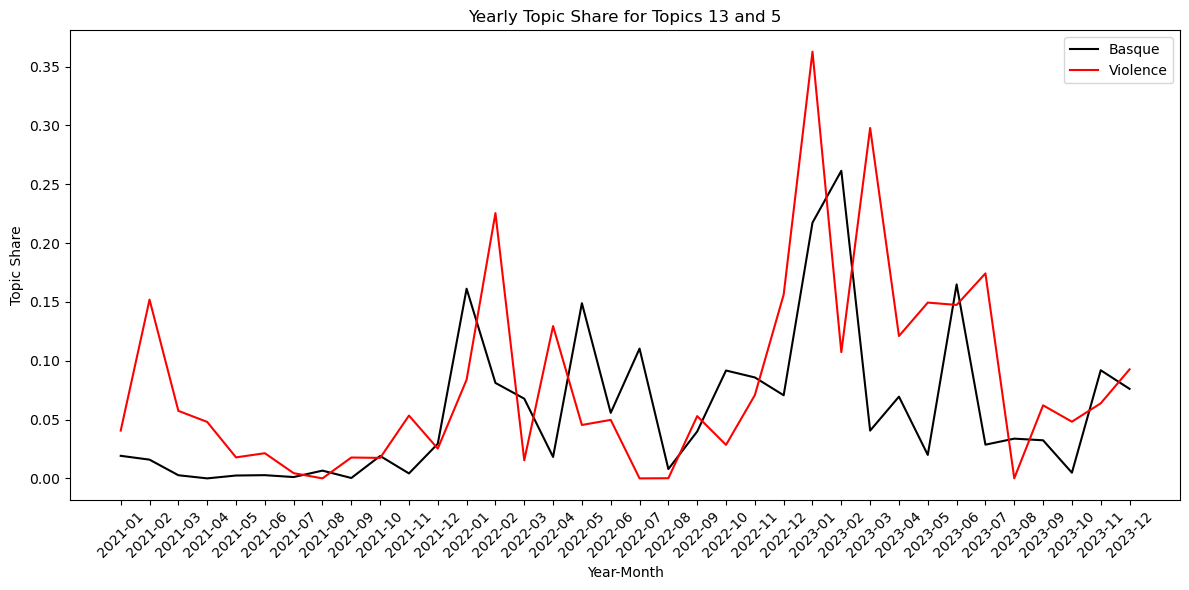

In [ ]:
import matplotlib.pyplot as plt

# Convert 'year_month' Period objects to strings using .loc
result_df.loc[:, 'year_month'] = result_df['year_month'].astype(str)

# Plotting
plt.figure(figsize=(12, 6))

# Plot each topic share over time within the filtered range
plt.plot(result_df['year_month'], result_df['topic_share_8'], color='black')
plt.plot(result_df['year_month'], result_df['topic_share_10'], color='red')



# Rotate the x-axis tick labels for better readability
plt.xticks(rotation=45)

# Adding labels and title
plt.xlabel('Year-Month')
plt.ylabel('Topic Share')
plt.title('Yearly Topic Share for Topics 8 and 10')

plt.legend()

# Show plot
plt.tight_layout()
plt.show()

In [28]:
# Plotting
plt.figure(figsize=(12, 6))

# Plot each topic share over time within the filtered range
plt.plot(result_df['year'], result_df['topic_share_4'], label='Economics', color='black')
plt.plot(result_df['year'], result_df['topic_share_7'], label='Business', color='blue')

# Set the x-axis to show every year as a tick mark
plt.xticks(result_df['year'][::3])  # Show every 3rd year to avoid clutter

# Rotate the x-axis tick labels for better readability
plt.xticks(rotation=45)

# Adding labels and title
plt.xlabel('Year')
plt.ylabel('Topic Share')
plt.title('Yearly Topic Share for Topics 4 and 7')

plt.legend()

# Show plot
plt.tight_layout()
plt.show()

NameError: name 'result_df' is not defined

<Figure size 1200x600 with 0 Axes>

## 2. Here will be the TA_session

In [ ]:
import pandas as pd
import numpy as np
import csv

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer 
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

import re
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import os
import re
from tqdm import tqdm
tqdm.pandas()
#getting a library of stopwords and defining a lemmatizer
porter=SnowballStemmer("english")
lmtzr = WordNetLemmatizer()

stop_words = set(stopwords.words('english'))

In [ ]:
path="/Users/ruimaciel/Desktop/Barcelona/NLP_I/NLP-Project/"
filename ="data/theeuropeancommission.csv"
EC_data = pd.read_csv(os.path.join(path, filename), sep=',', encoding='utf-8')
EC_data.head()

In [ ]:
#I will not lemmatize as I will did it previously

In [32]:
#all hail the implementation of CV in sci-kit learn
cv = CountVectorizer(ngram_range = (1,2), lowercase=True, min_df=0.001, max_df=0.4, stop_words='english')
# we get bigrams and unigrams, we ignore words that appear in less than 0.1% of the documents and more than 40% of the documents

cv.fit(EC_data_lemma.Text)

vectorized_text=cv.transform(EC_data_lemma.Text)
vectorized_text=vectorized_text.toarray()
print("document term matrix has size", vectorized_text.shape)

document term matrix has size (1320, 84030)


In [31]:
#gensim needs the dtm in a different sparce format
dtm_sparse = csr_matrix(dtm)

# Convert sparse matrix to gensim corpus
corpus = Sparse2Corpus(dtm_sparse, documents_columns=False)

# Create gensim dictionary from sklearn CountVectorizer vocabulary
vocabulary_gensim = {}
for key, val in cv.vocabulary_.items():
    vocabulary_gensim[val] = key

dictionary = corpora.Dictionary()
dictionary.id2token = vocabulary_gensim
dictionary.token2id = cv.vocabulary_

In [35]:
# ILLUSTRATION: 
cv2 = CountVectorizer(ngram_range = (1,2), lowercase=True, stop_words='english')
# we get bigrams and unigrams, we ignore words that appear in less than 0.1% of the documents and more than 40% of the documents

cv2.fit(EC_data_lemma.Text[0:1])
vocabulary = cv2.get_feature_names_out()

print(EC_data_lemma.Text[0])
print('\n\n')
print(vocabulary)


On 8 February 2024 Her Excellency, President of the European Commission, Ursula VON DER LEYEN, and His Excellency, Prime Minister of the Spanish government, Pedro Sánchez, made a joint visit to Nouakchott during which they met with His Excellency President of the Islamic Republic of Mauritania, Mohamed Ould Cheikh El Ghazouani.
The three leaders had in-depth discussions on, firstly, the strategic relations between Mauritania and the European Union and, secondly, the strong, friendly, bilateral relations between the Kingdom of Spain and the Islamic Republic of Mauritania.
The three leaders emphasised the depth and diversity of these relations, which cover a wide range of policy, economic, trade, cultural, cooperation and security matters.
Aware of the scope and importance of these links, they underlined, in particular, the essential principles guiding their cooperation: constructive dialogue, mutual respect, trust, transparency, and ongoing efforts to uphold their commitments and make t

In [36]:
EC_data_lemma.Text[0]

"On 8 February 2024 Her Excellency, President of the European Commission, Ursula VON DER LEYEN, and His Excellency, Prime Minister of the Spanish government, Pedro Sánchez, made a joint visit to Nouakchott during which they met with His Excellency President of the Islamic Republic of Mauritania, Mohamed Ould Cheikh El Ghazouani.\nThe three leaders had in-depth discussions on, firstly, the strategic relations between Mauritania and the European Union and, secondly, the strong, friendly, bilateral relations between the Kingdom of Spain and the Islamic Republic of Mauritania.\nThe three leaders emphasised the depth and diversity of these relations, which cover a wide range of policy, economic, trade, cultural, cooperation and security matters.\nAware of the scope and importance of these links, they underlined, in particular, the essential principles guiding their cooperation: constructive dialogue, mutual respect, trust, transparency, and ongoing efforts to uphold their commitments and ma

In [37]:
vectorized_title=cv.transform(EC_data_lemma.Text) # this uses the same vocabulary as the text
vectorized_title=vectorized_title.toarray()
print("document term matrix has size", vectorized_title.shape)
dtm=4*vectorized_title+vectorized_text # we give more weight to the title
print(type(dtm))

document term matrix has size (1320, 84030)
<class 'numpy.ndarray'>


In [38]:
from gensim import corpora, models
from gensim.matutils import Sparse2Corpus
from scipy.sparse import csr_matrix

#gensim needs the dtm in a different sparce format (from numpy to csr_matrix)
dtm_sparse = csr_matrix(dtm)

# Convert sparse matrix to gensim corpus
corpus = Sparse2Corpus(dtm_sparse, documents_columns=False)

# Create gensim dictionary from sklearn CountVectorizer vocabulary
vocabulary_gensim = {}
for key, val in cv.vocabulary_.items(): # remember cv has been fitted to the data
    vocabulary_gensim[val] = key

dictionary = corpora.Dictionary()
dictionary.id2token = vocabulary_gensim
dictionary.token2id = cv.vocabulary_


In [39]:
# Number of topics
num_topics = 10

# Build LDA model
lda_model = models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=20, random_state=42)


# Display the topics
topics = lda_model.print_topics(num_words=10)
for topic in topics:
    print(topic)

(0, '0.010*"vaccines" + 0.009*"health" + 0.007*"vaccine" + 0.006*"covid" + 0.006*"19" + 0.006*"covid 19" + 0.005*"pandemic" + 0.004*"doses" + 0.003*"vaccination" + 0.003*"response"')
(1, '0.010*"ukraine" + 0.005*"digital" + 0.004*"russia" + 0.004*"international" + 0.003*"war" + 0.003*"leyen" + 0.003*"der leyen" + 0.003*"high" + 0.003*"conference" + 0.002*"financial"')
(2, '0.009*"ukraine" + 0.004*"war" + 0.003*"russia" + 0.003*"dear" + 0.003*"country" + 0.003*"russian" + 0.002*"course" + 0.002*"example" + 0.002*"let" + 0.002*"right"')
(3, '0.004*"social" + 0.004*"bauhaus" + 0.003*"new european" + 0.003*"nextgenerationeu" + 0.003*"sure" + 0.003*"european bauhaus" + 0.003*"emissions" + 0.003*"recovery" + 0.003*"change" + 0.003*"digital"')
(4, '0.003*"hydrogen" + 0.003*"clean" + 0.003*"change" + 0.003*"example" + 0.002*"deal" + 0.002*"emissions" + 0.002*"course" + 0.002*"climate change" + 0.002*"green deal" + 0.002*"eur"')
(5, '0.019*"und" + 0.018*"die" + 0.015*"der" + 0.011*"wir" + 0.008

In [40]:
#The goal here is to compare the SVD with the LDA.

from sklearn.decomposition import TruncatedSVD

# Apply SVD, we choose n_components = 2 for simplicity
svd = TruncatedSVD(n_components=10)
U = svd.fit_transform(dtm)
Sigma = svd.singular_values_
VT = svd.components_


terms = cv.get_feature_names_out()
for i, comp in enumerate(VT):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key=lambda x: x[1], reverse=True)[:5]
    print("Topic " + str(i+1) + ": ", sorted_terms)

Topic 1:  [('ukraine', 0.21563227649817343), ('die', 0.20802454073961762), ('und', 0.20508744956456226), ('plan', 0.19891581324423996), ('der', 0.18802090383588585)]
Topic 2:  [('die', 0.41088835790999706), ('und', 0.40698362880167055), ('der', 0.2797903291448703), ('wir', 0.24695209457160613), ('das', 0.17480872761886596)]
Topic 3:  [('plan', 0.3891374628599923), ('resilience', 0.29524424979949965), ('recovery', 0.2749141932161482), ('recovery resilience', 0.26739584405547717), ('resilience plan', 0.1463372754678282)]
Topic 4:  [('ukraine', 0.6921320334915072), ('war', 0.16179374854467543), ('russia', 0.15539298300475485), ('ukrainian', 0.12142720312246447), ('russian', 0.09181873248632857)]
Topic 5:  [('et', 0.2430867783062259), ('la', 0.20893659753359053), ('les', 0.16394991239455392), ('nous', 0.13991949683852611), ('le', 0.13526509917307228)]
Topic 6:  [('et', 0.36128623877802785), ('la', 0.30763101250856045), ('les', 0.24145011305194866), ('nous', 0.20315174470158245), ('le', 0.2

In [41]:

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis


vis_data = gensimvis.prepare(lda_model, corpus, dictionary)

pyLDAvis.display(vis_data)


In [42]:
#This is to do coherence. It is purely mathematical so it may not be good.

from gensim.models.coherencemodel import CoherenceModel

cm = CoherenceModel(model=lda_model, corpus=corpus, coherence='u_mass')
coherence = cm.get_coherence()  # get coherence value
coherence

-1.0790670875382158

In [43]:
#This took ages to run. As it is quite irrelevant, I would not run it again.


def compute_coherence(num_topics, corpus, dictionary):
    lda_model = models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=20, random_state=42)
    coherence_model = CoherenceModel(model=lda_model, corpus=corpus, coherence='u_mass')
    coherence = coherence_model.get_coherence()
    return coherence

coherence_values = []


min_topics = 2
max_topics = 10
step_size = 1

# Iterate over different numbers of topics
for num_topics in range(min_topics, max_topics + 1, step_size):
    coherence = compute_coherence(num_topics, corpus, dictionary)
    coherence_values.append(coherence)
    print(f"Number of Topics: {num_topics}, Coherence: {coherence}")

# Plotting coherence values vs. number of topics
import matplotlib.pyplot as plt

plt.plot(range(min_topics, max_topics + 1, step_size), coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Coherence vs. Number of Topics")
plt.xticks(range(min_topics, max_topics + 1, step_size))
plt.grid(True)
plt.show()

Number of Topics: 2, Coherence: -1.3763543754393361
Number of Topics: 3, Coherence: -1.7484346534998096
Number of Topics: 4, Coherence: -1.5046405685902813
Number of Topics: 5, Coherence: -1.7359650549689234
Number of Topics: 6, Coherence: -1.763363302375683
Number of Topics: 7, Coherence: -1.7521203580531481
Number of Topics: 8, Coherence: -1.0807986978098783
Number of Topics: 9, Coherence: -1.3054380033496542
Number of Topics: 10, Coherence: -1.0790670875382158


KeyboardInterrupt: 

In [44]:
#Here we do another LDA, but we change the alpha paramenter. There is a need to understand what is going here.


num_topics = 10
lda_model = models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=20, random_state=42,alpha=20)


lda_model.show_topics

vis_data = gensimvis.prepare(lda_model, corpus, dictionary)

pyLDAvis.display(vis_data)

In [ ]:
#Then we have guided LDA, lets not do it now.